In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%load_ext jupyter_cms

import numpy as np
import random
import matplotlib.pyplot as plt
from utils import cifar_dataset_util

In [167]:
# load data.. refer to utils/cifar_dataset_util.ipynb 
# for the method that load and decompress CIFAR-10 ** load_all_cifar10(..) **
# helper methods to download  & decompress CIFAR-10 from URL.
# CIFAR-10 provided by toronto.edu dataset 
# --------------------------------------------

cifar_path = "./datasets/cifar-10-batches-py"
Xtr, Ytr, Xte, Yte = cifar_dataset_util.load_all_cifar10(cifar_path)

print "Xtr ", Xtr.shape
print "Ytr ", Ytr.shape
print "Xte ", Xte.shape
print "Yte ", Yte.shape

Xtr  (50000, 32, 32, 3)
Ytr  (50000,)
Xte  (10000, 32, 32, 3)
Yte  (10000,)


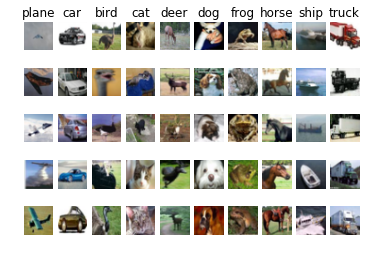

In [3]:
# plot some images from the loaded data
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(Ytr == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(Xtr[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [218]:
# sampling the data
num_training, num_testing = 5000, 500
mask = range(num_training)
Xtr = Xtr[mask]
Ytr = Ytr[mask]

mask = range(num_testing)
Xte = Xte[mask]
Yte = Yte[mask]

In [170]:
# reshaping the images
Xtr = Xtr.reshape(Xtr.shape[0], -1)
Xte = Xte.reshape(Xte.shape[0], -1)

print "training shape: ", Xtr.shape, " testing shape: ", Xte.shape

training shape:  (5000, 3072)  testing shape:  (500, 3072)


In [177]:
# just for testing ... purpose I declared KKClassifier here 
import numpy as np

class KNNClassifier(object):
    
    def __init__(sefl):
        pass
    
    # Method the train the model
    # KNN is just remembering the data 
    def train(self, Xtr, Ytr):
        self.X = Xtr
        self.Y = Ytr
    
    # prediction based on similarity matrix
    def predict(self, Xte, k=1):
        dists = self.compute_distances(Xte)
        num_test = Xte.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            closest_y = [self.Y[j] for j in np.argsort(dists[i])[:k]]
            (values, counts) = np.unique(closest_y, return_counts=True)
            ind = np.argmax(counts)
            y_pred[i] = values[ind]
            
        return y_pred
    
    
    # Compute the distance L2 between training set
    # and test set with two loops!!! very inefficient  
    def compute_distances_two_loops(self, Xte):
        Xtr = self.X
        num_train = Xtr.shape[0]
        num_test = Xte.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            for j in range(num_train):
                dists[i, j] = np.sqrt(np.sum(Xtr[j] - Xte[i]) ** 2)
        return dists
    
    # Compute the distance L2 between training set
    # and test set without very fast Vectorised version of two_loops above 
    def compute_distances(self, Xte):
        num_train = self.X.shape[0]
        num_test = Xte.shape[0]
        dists = np.zeros((num_test, num_train))
        tDot = np.multiply(np.dot(Xte, self.X.T), -2)
        t1 = np.sum(np.square(Xte), axis=1, keepdims=True)
        t2 = np.sum(np.square(self.X), axis=1)
        tDot = np.add(t1, tDot)
        tDot = np.add(tDot, t2)
        dists = np.sqrt(tDot)
        return dists

In [180]:
# Instanciate the knn classifier
knn = KNNClassifier()

# train the model
knn.train(Xtr, Ytr)

Now lets classify test set with the built model
- First step is the compute between all the elements in the test set and all the elements in the traing set
    - to compute this distance we can use for instance L1, L2 or some other distance 
- Given the distances we find the top 'k' closest elements to each test element
- The element will be classified with the most frequent class in the top 'k' closest elements

In [181]:
# compute the distance matrix
dists = knn.compute_distances(Xte)
dists.shape

(500, 5000)

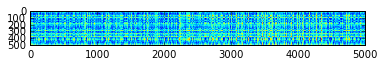

In [183]:
plt.imshow(dists, interpolation='none')
plt.show()

In [219]:
# make prediction
YPred = knn.predict(Xte, k=1)
# Check the accuracy of the model
num_correct_predictions = np.sum(YPred == Yte)
accuracy = float(num_correct_predictions) / num_testing

print " %d correct prediction / %d images ==> accuracy is %f %%" % (num_correct_predictions, num_training, accuracy)

 137 correct prediction / 5000 images ==> accuracy is 0.274000 %


In [221]:
# test the model with k = 5
YPred = knn.predict(Xte, k=5)

# Check the accuracy of the model
num_correct_predictions = np.sum(YPred == Yte)
accuracy = float(num_correct_predictions) / num_testing

# np.mean(YPred==Yte)

print " %d correct prediction / %d images ==> accuracy is %f %%" % (num_correct_predictions, num_training, accuracy)

 139 correct prediction / 5000 images ==> accuracy is 0.278000 %
0.278


## Cross validation
Now we will split our traing set & test set into folds
- We will train our model for different hyperparameter k values
    - On all the folds minus one and test the model with the remaining fold this will give us k & accurancy at each iteration
- At the end we choose the k which give the best accuracy

In [203]:
# number of folds
num_folds = 5
num_test = Xtr.shape[0] / 5
folds_Xtr = np.array_split(Xtr, 5)
folds_Ytr = np.array_split(Ytr, 5)
hypp_k = [1, 2, 3, 5, 8, 10, 15, 20]

# dictionnary to keep trace of k => list(accuracies in each fold)
k_accuracies = {}

for k in hypp_k:
    # initialize k_accuracies[k] with empty list
    k_accuracies[k] = []
    for f in range(num_folds):
        # remove the fold in the current index
        sub_folds_Xtr = [v for x, v in enumerate(folds_Xtr) if x != f] 
        sub_folds_Ytr = [v for x, v in enumerate(folds_Ytr) if x != f]
        # concatenate the remaining folds
        sub_folds_Xtr = np.concatenate(sub_folds_Xtr)
        sub_folds_Ytr = np.concatenate(sub_folds_Ytr)
        knn.train(sub_folds_Xtr, sub_folds_Ytr)
        YPred = knn.predict(folds_Xtr[f], k)
        num_correct = np.sum(folds_Ytr[f] == YPred)
        accuracy = float(num_correct) / num_test
        k_accuracies[k].append(accuracy)
        print "for k %d ==> accuracy is %f %% in fold %d" % (k, accuracy, f)

for k 1 ==> accuracy is 0.263000 % in fold 0
for k 1 ==> accuracy is 0.257000 % in fold 1
for k 1 ==> accuracy is 0.264000 % in fold 2
for k 1 ==> accuracy is 0.278000 % in fold 3
for k 1 ==> accuracy is 0.266000 % in fold 4
for k 2 ==> accuracy is 0.235000 % in fold 0
for k 2 ==> accuracy is 0.219000 % in fold 1
for k 2 ==> accuracy is 0.234000 % in fold 2
for k 2 ==> accuracy is 0.247000 % in fold 3
for k 2 ==> accuracy is 0.252000 % in fold 4
for k 3 ==> accuracy is 0.239000 % in fold 0
for k 3 ==> accuracy is 0.249000 % in fold 1
for k 3 ==> accuracy is 0.240000 % in fold 2
for k 3 ==> accuracy is 0.266000 % in fold 3
for k 3 ==> accuracy is 0.254000 % in fold 4
for k 5 ==> accuracy is 0.248000 % in fold 0
for k 5 ==> accuracy is 0.266000 % in fold 1
for k 5 ==> accuracy is 0.280000 % in fold 2
for k 5 ==> accuracy is 0.292000 % in fold 3
for k 5 ==> accuracy is 0.280000 % in fold 4
for k 8 ==> accuracy is 0.262000 % in fold 0
for k 8 ==> accuracy is 0.282000 % in fold 1
for k 8 ==

<function matplotlib.pyplot.show>

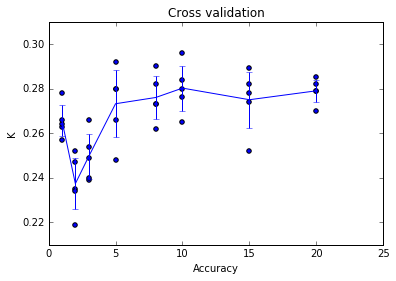

In [212]:
# plot the Cross Validation

for k in hypp_k:
    accuracies = k_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

mean = [np.mean(v) for k,v in sorted(k_accuracies.items())]
std = [np.std(v) for k,v in sorted(k_accuracies.items())]
plt.errorbar(hypp_k, mean, yerr=std)

plt.title("Cross validation")
plt.xlabel("Accuracy")
plt.ylabel("K")
plt.show

In [217]:
# From the plot above we have the value k = 10 give the best accuracy
# We will test with this value.
knn = KNNClassifier()
knn.train(Xtr, Ytr)
YPred = knn.predict(Xte, k=10)
num_correct = np.sum(YPred == Yte)
accuracy = float(num_correct) / Yte.shape[0]

print "with CV parameter we got %f %% accuracy" % accuracy

with CV parameter we got 0.282000 % accuracy
